In [7]:
import pandas as pd
import numpy as np
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict
from nltk.corpus import wordnet as wn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection, naive_bayes, svm
from sklearn.metrics import accuracy_score, confusion_matrix
from matplotlib import pyplot as plt

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.utils.multiclass import unique_labels
np.random.seed(500)


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\agokh\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [10]:
Corpus = pd.read_csv(r"C:\Users\agokh\Desktop\ML Data\Reuters@ReutersBiz Tweets_V3_2_new_class.csv",encoding='latin-1',sep=";")

In [11]:
# Step - a : Remove blank rows if any.
Corpus['text'].dropna(inplace=True)
# Step - b : Change all the text to lower case. This is required as python interprets 'dog' and 'DOG' differently
Corpus['text'] = [entry.lower() for entry in Corpus['text']]
# Step - c : Tokenization : In this each entry in the corpus will be broken into set of words
Corpus['text']= [word_tokenize(entry) for entry in Corpus['text']]

In [12]:

# WordNetLemmatizer requires Pos tags to understand if the word is noun or verb or adjective etc. By default it is set to Noun
tag_map = defaultdict(lambda : wn.NOUN)
tag_map['J'] = wn.ADJ
tag_map['V'] = wn.VERB
tag_map['R'] = wn.ADV
for index,entry in enumerate(Corpus['text']):
    # Declaring Empty List to store the words that follow the rules for this step
    Final_words = []
    # Initializing WordNetLemmatizer()
    word_Lemmatized = WordNetLemmatizer()
    # pos_tag function below will provide the 'tag' i.e if the word is Noun(N) or Verb(V) or something else.
    for word, tag in pos_tag(entry):
        # Below condition is to check for Stop words and consider only alphabets
        if word not in stopwords.words('english') and word.isalpha():
            word_Final = word_Lemmatized.lemmatize(word,tag_map[tag[0]])
            Final_words.append(word_Final)
    # The final processed set of words for each iteration will be stored in 'text_final'
    Corpus.loc[index,'text_final'] = str(Final_words)

In [13]:
sss = StratifiedShuffleSplit(n_splits=12, test_size=0.3, random_state=0)
X , y = Corpus['text_final'], Corpus['label']

Y_list = y.unique()
sss.get_n_splits(X,y)

for train_index, test_index in sss.split(X, y):
    Train_X, Test_X = X[train_index], X[test_index]
    Train_Y, Test_Y = y[train_index], y[test_index]


In [14]:
Encoder = LabelEncoder()
Train_YE = Encoder.fit_transform(Train_Y)
Test_YE = Encoder.fit_transform(Test_Y)

In [15]:
Tfidf_vect = TfidfVectorizer(max_features=5000)
Tfidf_vect.fit(Corpus['text_final'])
Train_X_Tfidf = Tfidf_vect.transform(Train_X)
Test_X_Tfidf = Tfidf_vect.transform(Test_X)

In [16]:
a = Train_X_Tfidf.toarray()

In [17]:
# Classifier - Algorithm - SVM
# fit the training dataset on the classifier
SVM = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
SVM.fit(Train_X_Tfidf,Train_YE)
# predict the labels on validation dataset
predictions_SVM = SVM.predict(Test_X_Tfidf)
# Use accuracy_score function to get the accuracy
print("SVM Accuracy Score -> ",accuracy_score(predictions_SVM, Test_YE)*100)

SVM Accuracy Score ->  51.35135135135135


In [18]:
print (predictions_SVM)

[ 6  6  3  6  9  6  4  4  2  9  6  4  3  3  3  6  2  4 10  2 10  2  2  3
  6  2  6  4  4  3  9  5  6  9  6  6  2  4  6  7  3  3  6  7  3  0  9 10
  9 10  2  3  2  3  6  6  4  4  3 10  2  6  3  6  3  3  2  3  6  6  4 10
  2  6  2  0  6  4  7  3  6  2  8  6  7  3  9  2  9  2  6  4  0  9  6  6
  6  4  6  2  6  0  4  3  6  2  8  2  9  6  9  9  3  6  6  9  6  4  6  6
  7  6  9  2  2  4  2  6  4  2  2 10  9  6  6  2  3  0 10  4  6  6  6 10
  2  3  4  2]


In [19]:
confusion_matrix(Test_YE, predictions_SVM)

array([[ 5,  0,  2,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  2,  0,  0,  0,  1,  0,  0,  0,  0],
       [ 0,  0, 10,  0,  3,  0,  6,  0,  0,  0,  0],
       [ 0,  0,  1, 19,  2,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  4,  1,  7,  0,  7,  1,  0,  0,  0],
       [ 0,  0,  1,  0,  1,  0,  6,  0,  0,  2,  1],
       [ 0,  0,  2,  2,  1,  1, 11,  0,  1,  0,  0],
       [ 0,  0,  1,  0,  2,  0,  2,  4,  0,  0,  2],
       [ 0,  0,  4,  0,  1,  0,  5,  0,  1,  0,  0],
       [ 0,  0,  0,  0,  1,  0,  0,  0,  0, 13,  0],
       [ 0,  0,  0,  0,  1,  0,  5,  0,  0,  0,  6]], dtype=int64)

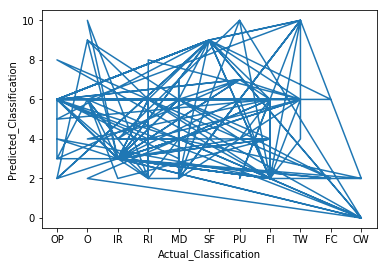

In [20]:
plt.xlabel("Actual_Classification") 
plt.ylabel("Predicted_Classification") 
plt.plot(Test_Y,predictions_SVM) 
plt.show()

In [21]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

Confusion matrix, without normalization
[[ 5  0  2  0  0  0  0  0  0  0  0]
 [ 0  0  2  0  0  0  1  0  0  0  0]
 [ 0  0 10  0  3  0  6  0  0  0  0]
 [ 0  0  1 19  2  0  0  0  0  0  0]
 [ 0  0  4  1  7  0  7  1  0  0  0]
 [ 0  0  1  0  1  0  6  0  0  2  1]
 [ 0  0  2  2  1  1 11  0  1  0  0]
 [ 0  0  1  0  2  0  2  4  0  0  2]
 [ 0  0  4  0  1  0  5  0  1  0  0]
 [ 0  0  0  0  1  0  0  0  0 13  0]
 [ 0  0  0  0  1  0  5  0  0  0  6]]


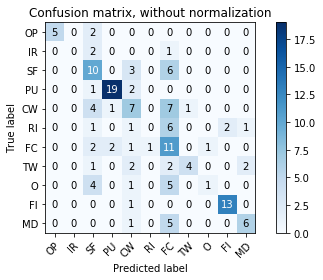

In [22]:

plot_confusion_matrix(Test_YE, predictions_SVM, classes=Y_list,normalize=False,title='Confusion matrix, without normalization')
plt.show()
